# Segmenting and Clustering Neighborhoods in Toronto
_Week 3 Project_

**To Do:**
 * Increase limit
 * Create link to notebook using: https://nbviewer.jupyter.org/

**Goals:**
* Scrape neighborhood data from Wikipedia page
* Retrieve lat/lng coordinates for each neighborhood
* Explore and cluster neighborhoods

#### Import Required Libraries

In [196]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Scrape Wiki Page

In [21]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')
# print(soup.prettify()) # Uncomment to view scraped HTML

In [22]:
table = soup.find("table", class_="wikitable")
table_body = table.tbody
table_rows = table_body.findAll("tr")

#### Process Table HTML

In [23]:
cols = ["PostalCode", "Borough", "Neighborhood"]
data = []

for row in table_rows:
    cells = row.findAll("td")
    if len(cells) != 0:
        postcode = cells[0].text.strip()
        borough = cells[1].text.strip()
        neighborhood = cells[2].text.strip()
        if borough != "Not assigned":
            if neighborhood == "Not assigned":
                neighborhood = borough
            data.append([postcode, borough, neighborhood])
df = pd.DataFrame(data)
df.columns = cols
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


#### Group by PostalCode

In [24]:
# Technique 1
df_grouped = df.groupby(['PostalCode','Borough'])['Neighborhood'].agg(lambda col: ', '.join(col))

# Technique 2
# df_grouped = df.groupby(['PostalCode','Borough']).Neighborhood.unique().apply(lambda x: ', '.join(x)).reset_index()

toronto = df_grouped.to_frame().reset_index()
toronto

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


**Check Number of Rows**

In [25]:
print("The Toronto dataframe has {} rows.".format(toronto.shape[0]))

The Toronto dataframe has 103 rows.


#### Get Coordinates of Postal Codes
(Imported from csv as geocoder did not work for me)

In [26]:
## Add two empty columns for lat/lng
toronto["Latitude"], toronto["Longitude"] = np.nan, np.nan

**Attempted to use Geocoder:**

In [27]:
import geocoder

In [28]:
def get_coords(postal_code):
    coords = None

    while (coords is None):
        g = geocoder.google("{}, Toronto, Ontario".format(postal_code))
        coords = g.latlng

    lat = coords[0]
    lng = coords[1]
    return lat, lng

In [29]:
## Apply get coords function to each postal code ** Did not work **
# toronto["Latitude"], toronto["Longitude"] = zip(*toronto["PostalCode"].apply(get_coords))

**Pulled Lat/Lngs from CSV**

In [30]:
coords = pd.read_csv("assets/Geospatial_Coordinates.csv").set_index("Postal Code")
coords.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [31]:
unique_postal_codes = toronto["PostalCode"].unique()
toronto = toronto.set_index("PostalCode")

for p in unique_postal_codes:
    toronto.loc[p, "Latitude"], toronto.loc[p, "Longitude"] = coords.loc[p, "Latitude"], coords.loc[p, "Longitude"]
    
toronto = toronto.reset_index()

In [32]:
toronto.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### Get the Lat/Lng of Toronto

In [33]:
from geopy.geocoders import Nominatim
import folium

In [34]:
address = "Toronto, Ontario"

geolocator = Nominatim(user_agent="ca_user")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Toronto, Ontario are 43.653963, -79.387207.


#### Create Map Plotting Helper Function

In [35]:
def plot_locations(center_lat, center_lng, locations_df):
    toronto_map = folium.Map(location=[center_lat, center_lng], zoom_start=11)

    folium.vector_layers.CircleMarker(
        [center_lat, center_lng],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        tooltip="Toronto"
    ).add_to(toronto_map)

    for lat, lng, label in zip(locations_df["Latitude"], locations_df["Longitude"], locations_df["Neighborhood"]):
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=3,
            color="blue",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            popup=label
        ).add_to(toronto_map)
        
    return toronto_map

#### Map All Neighborhoods

In [36]:
plot_locations(latitude, longitude, toronto)

#### For Simplicity & Speed, Let's Look at a Subset of the Boroughs

In [37]:
toronto_data = toronto[toronto["Borough"].str.contains("Toronto")]
print(toronto_data.shape)
toronto_data.head()

(38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


**Visualize Subset of Locations**

In [38]:
plot_locations(latitude, longitude, toronto_data)

#### Get Nearby Venues for Each Borough using Foursquare API

In [39]:
# import Foursquare developer credentials
%run "credentials.py"

**Create URL & Send GET Request**

In [40]:
radius = 500
limit = 2

def get_nearby_venues(df):
    venues_list = []
    
    for lat, lng, label in zip(df["Latitude"], df["Longitude"], df["PostalCode"]): 
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            lat, lng, 
            radius, limit)
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        venues_list.append([(
            label,
            lat,
            lng,
            venue["venue"]["name"],
            venue["venue"]["location"]["lat"],
            venue["venue"]["location"]["lng"],
            venue["venue"]["categories"][0]["name"]
        ) for venue in results])
    
    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ["PostalCode", "BoroughLatitude", "BoroughLongitude", 
                             "VenueName", "VenueLatitude", "VenueLongitude", "VenueCategory"]
    
    return nearby_venues

In [41]:
nearby_venues = get_nearby_venues(toronto_data)

**Examine Results**

In [42]:
print(nearby_venues.shape)
print("There are {} unique venue categories.\n".format(len(nearby_venues["VenueCategory"].unique())))
nearby_venues.head()

(76, 7)
There are 48 unique venue categories.



,PostalCode,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4K,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
3,M4K,43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop
4,M4L,43.668999,-79.315572,British Style Fish & Chips,43.668723,-79.317139,Fish & Chips Shop


In [43]:
nearby_venues.groupby("PostalCode").count()

,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,,,,,,
M4E,2,2,2,2,2,2
M4K,2,2,2,2,2,2
M4L,2,2,2,2,2,2
M4M,2,2,2,2,2,2
M4N,2,2,2,2,2,2
M4P,2,2,2,2,2,2
M4R,2,2,2,2,2,2
M4S,2,2,2,2,2,2
M4T,2,2,2,2,2,2


#### Use One-Hot Encoding to Convert Categories into Numerical Values

In [172]:
nearby_venues_onehot = pd.get_dummies(nearby_venues["VenueCategory"])
nearby_venues_onehot["PostalCode"] = nearby_venues["PostalCode"]

# Re-order columns
cols = [nearby_venues_onehot.columns[-1]] + list(nearby_venues_onehot.columns.values[:-1])
nearby_venues_onehot = nearby_venues_onehot[cols]

nearby_venues_onehot.head()

,PostalCode,Airport,Airport Lounge,Arts & Crafts Store,Bakery,Bar,Brewery,Building,Burrito Place,Café,...,Restaurant,Sandwich Place,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tennis Court,Theme Restaurant,Trail,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4L,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
nearby_venues_onehot.shape

(76, 49)

#### Group by PostalCode to get Frequency

In [174]:
nearby_venues_grouped = nearby_venues_onehot.groupby("PostalCode").mean().reset_index()
nearby_venues_grouped

,PostalCode,Airport,Airport Lounge,Arts & Crafts Store,Bakery,Bar,Brewery,Building,Burrito Place,Café,...,Restaurant,Sandwich Place,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tennis Court,Theme Restaurant,Trail,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
5,M4P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,M4R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
7,M4S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,M4T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
9,M4V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


#### Get Top Categories for each Postal Code

In [175]:
def get_top_categories(idx, num=5):
    top = nearby_venues_grouped.iloc[idx, 1:].T.reset_index()
    top.columns = ["VenueCategory", "Frequency"]
    top["Frequency"] = top["Frequency"].astype(float)
    top = top.sort_values("Frequency", ascending=False).set_index("VenueCategory").head(num)
    return top

In [176]:
example = get_top_categories(0)
example

,Frequency
VenueCategory,
Health Food Store,0.5
Trail,0.5
Park,0.0
Ice Cream Shop,0.0
Indian Restaurant,0.0


**Create DataFrame for Top Categories**

In [177]:
cols = ["PostalCode"]
endings = ["st", "nd", "rd"]

for i in range(10):
    if i < 3:
        cols.append(str(i + 1) + endings[i] + " Most Common Category")
    else:
        cols.append(str(i + 1) + "th Most Common Category")

top_df = pd.DataFrame(columns=cols)
top_df["PostalCode"] = nearby_venues_grouped["PostalCode"]

**Populate DataFrame**

In [178]:
for idx, row in top_df.iterrows():
    top_df.iloc[idx, 1:] = get_top_categories(idx, 10).index.values

top_df.head()

,PostalCode,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,Health Food Store,Trail,Park,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
1,M4K,Ice Cream Shop,Greek Restaurant,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
2,M4L,Ice Cream Shop,Fish & Chips Shop,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
3,M4M,Ice Cream Shop,Sandwich Place,Airport,Park,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
4,M4N,Park,Swim School,Airport,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant


**Examine Results**

In [179]:
top_df["1st Most Common Category"].value_counts()

Gym                    4
Ice Cream Shop         4
Park                   2
Liquor Store           2
Steakhouse             2
Italian Restaurant     2
Playground             1
Tennis Court           1
Brewery                1
Burrito Place          1
Airport                1
Yoga Studio            1
Dance Studio           1
Health Food Store      1
Bakery                 1
Food                   1
Japanese Restaurant    1
Grocery Store          1
Arts & Crafts Store    1
Creperie               1
Indian Restaurant      1
Food & Drink Shop      1
Coffee Shop            1
Neighborhood           1
Dog Run                1
Café                   1
Bar                    1
Pizza Place            1
Name: 1st Most Common Category, dtype: int64

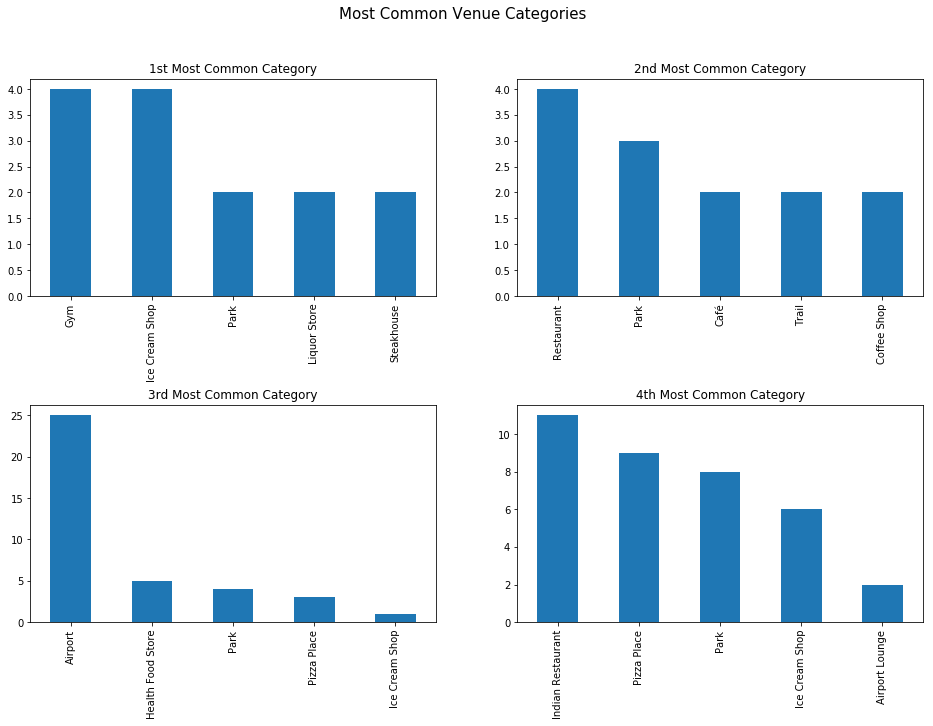

In [180]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
plt.subplots_adjust(hspace = 0.5)

for i in range(4):
    if i < 2:
        top_df[top_df.columns[i+1]].value_counts().head().plot(kind="bar", ax=axs[0][i], title=top_df.columns[i+1])
    else:
        top_df[top_df.columns[i+1]].value_counts().head().plot(kind="bar", ax=axs[1][i%2], title=top_df.columns[i+1])

plt.suptitle("Most Common Venue Categories", fontsize=15)
plt.show()

#### Cluster Neighborhoods

In [181]:
n_clusters = 5

clustering_df = nearby_venues_grouped.drop(columns="PostalCode")

In [182]:
clustering_df.head()

,Airport,Airport Lounge,Arts & Crafts Store,Bakery,Bar,Brewery,Building,Burrito Place,Café,Clothing Store,...,Restaurant,Sandwich Place,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tennis Court,Theme Restaurant,Trail,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0


In [183]:
k_means = KMeans(n_clusters=n_clusters, random_state=0)
k_means.fit(clustering_df)

cluster_results = k_means.labels_
cluster_results

array([0, 4, 4, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 3, 1, 3, 0, 2, 2,
       4, 0, 0, 2, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0])

#### Format Final DataFrame
**Merge Cluster Results with Top Categories DataFrame**

In [188]:
result_df = top_df.copy()
result_df.insert(1, "Cluster", cluster_results)
result_df.head()

,PostalCode,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,0,Health Food Store,Trail,Park,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
1,M4K,4,Ice Cream Shop,Greek Restaurant,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
2,M4L,4,Ice Cream Shop,Fish & Chips Shop,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
3,M4M,4,Ice Cream Shop,Sandwich Place,Airport,Park,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
4,M4N,0,Park,Swim School,Airport,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant


**Merge Location Data**

In [189]:
result_df = result_df.merge(toronto_data, how="inner", on="PostalCode")
result_df.head()

,PostalCode,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,Borough,Neighborhood,Latitude,Longitude
0,M4E,0,Health Food Store,Trail,Park,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,4,Ice Cream Shop,Greek Restaurant,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,4,Ice Cream Shop,Fish & Chips Shop,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,4,Ice Cream Shop,Sandwich Place,Airport,Park,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,East Toronto,Studio District,43.659526,-79.340923
4,M4N,0,Park,Swim School,Airport,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Central Toronto,Lawrence Park,43.728020,-79.388790


**Rearrange Columns**

In [190]:
cols = result_df.columns.values
new_cols = list(cols[0:1]) + list(cols[-4:]) + list(cols[1:-4])
result_df = result_df[new_cols]
result_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Park,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,4,Ice Cream Shop,Greek Restaurant,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,4,Ice Cream Shop,Fish & Chips Shop,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
3,M4M,East Toronto,Studio District,43.659526,-79.340923,4,Ice Cream Shop,Sandwich Place,Airport,Park,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Airport,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant


#### Examine Clusters

In [206]:
result_df[result_df["Cluster"] == 0].head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Park,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Airport,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,Food & Drink Shop,Park,Airport,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0,Yoga Studio,Diner,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Museum
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Café,Dessert Shop,Airport,Pizza Place,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant


#### Visualize Clusters

In [205]:
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)
                         
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, postal_code, borough, cluster in zip(result_df["Latitude"], result_df["Longitude"], result_df["PostalCode"], result_df["Borough"], result_df["Cluster"]):
    label = "{}: {} (Cluster {})".format(postal_code, borough, cluster)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        color=rainbow[cluster],
        fill_color=rainbow[cluster],
        fill_opacity=0.6,
        tooltip=label
    ).add_to(cluster_map)

cluster_map